# Setup Logging & Imports

In [1]:
DEBUG = True

### Setting up logging

In [2]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("pipeline")

# Show info messages if DEBUG mode is enabled
if DEBUG:
    logger.setLevel(logging.DEBUG)
    logger.debug("DEBUG mode is enabled. Detailed logs will be shown.")
else:
    logger.setLevel(logging.INFO)
    logger.info("DEBUG mode is disabled. Only essential logs will be shown.")

DEBUG:pipeline:DEBUG mode is enabled. Detailed logs will be shown.


### Imports

In [3]:
import os

# We set up CUDA first to ensure it is configured correctly
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
CUDA_DEVICE = "cuda:0"

In [ ]:
from pipeline.proj import load_projection_mat, reformat_sinogram, interpolate_projections, pad_and_reshape, divide_sinogram
from pipeline.aggregate_prj import aggregate_saved_projections
# from .aggregate_ct import aggregate_saved_volumes
from pipeline.apply_model import apply_model_to_projections, load_model
# from .infer3d import inference_3d
from pipeline.utils import ensure_dir, read_scans_agg_file
import torch
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import yaml
import importlib
import copy
from tqdm import tqdm
import gc

if not torch.cuda.is_available():
    logger.error("CUDA is not available. Please check your PyTorch installation. Using CPU instead...this will be slow.")
    CUDA_DEVICE = "cpu"

# TODO run FDK via: FFrecon_reconFDK(input_mat, output_mat); in file "FFrecon_fullFDK.m"
# TODO add input verification?
# TODO add a way for the user to add more data (since currently if there is any, it will skip the processing entirely)

# Configuration

In [ ]:
# Scans to convert to PyTorch tensors
# Put None if you don't have any scans to convert
# See the README for how to write this file correctly
# NOTE: This will throw an error if the scan has already been converted
#       If you would like to re-convert a scan,
#       you can delete the file manually
# SCANS_CONVERT = 'scans_convert_to_pt.txt'
SCANS_CONVERT = None

# Phase of the project (all data, models, etc. will be saved under this phase)
PHASE = "7"

# If this data version already exists in this phase, it will be loaded
# Otherwise it will be created using whatever the most updated data creation script is
DATA_VERSION = '13'

# Scans to use for training, val, and testing
# Set this to None if you don't want to do any aggregation
# See the README for how to write this file correctly
# NOTE: This will throw an error if there are already aggregated scans
#       (even if they are not the same as the ones in this file)
#       If you would like to re-aggregate,
#       you can delete the file manually or change the data version
SCANS_AGG = 'scans_to_agg.txt'
# SCANS_AGG = None

# List of yaml files that contain configurations for the pipeline
# Each file should contain the paramters for a specific model/ensemble
CONFIG_FILES = [
    # "config_01epoch.yaml",
    "config_20epoch.yaml",
]

# Base directory
WORK_ROOT = "D:/NoahSilverberg/ngCBCT"

# NSG_CBCT Path where the raw matlab data is stored
NSG_CBCT_PATH = "D:/MitchellYu/NSG_CBCT"

### Some immediate variable definitions and setting changes based on the configuration...

In [6]:
# Directories derived from bases
PHASE_DATAVER_DIR = os.path.join(
    WORK_ROOT, f"phase{PHASE}", f"DS{DATA_VERSION}"
)  # everything should go inside this directory
MODEL_DIR = os.path.join(PHASE_DATAVER_DIR, "model")  # for trained models
RESULT_DIR = os.path.join(PHASE_DATAVER_DIR, "result")  # for outputs of CNN
AGG_DIR = os.path.join(
    PHASE_DATAVER_DIR, "agg"
)  # for aggregated data (for PD and ID training)

# Make the folders if they don't already exist
ensure_dir(PHASE_DATAVER_DIR)
ensure_dir(MODEL_DIR)
ensure_dir(RESULT_DIR)
ensure_dir(AGG_DIR)

logger.debug("All directories are set up successfully.")

DEBUG:pipeline:All directories are set up successfully.


# Data Preparation: projection interpolation

In [7]:
# Ensure the output directories exist
g_dir = os.path.join(WORK_ROOT, 'data_pt', 'prj', 'gated')
ng_dir = os.path.join(WORK_ROOT, 'data_pt', 'prj', 'ng')
ensure_dir(g_dir)
ensure_dir(ng_dir)

if SCANS_CONVERT is not None:
    # Read the scans to convert file
    with open(SCANS_CONVERT, "r") as f:
        SCANS_CONVERT = []
        for line in f:
            line = line.strip()
            if not line:
                continue
            patient, scan, scan_type = line.split()
            SCANS_CONVERT.append((patient, scan, scan_type))

    logger.debug(f"Loaded scan list for conversion: {SCANS_CONVERT}")

    logger.info("Starting to process projection data...")

    for patient, scan, scan_type in SCANS_CONVERT:
        # Load the projection data from the matlab files
        odd_index, angles, prj = load_projection_mat(patient, scan, scan_type, NSG_CBCT_PATH)

        # Log shapes of loaded data
        logger.debug(f'Processing patient {patient}, scan {scan}, type {scan_type}')
        logger.debug(f'Loaded odd_index shape: {odd_index.shape}')
        logger.debug(f'Loaded angles shape: {angles.shape}')
        logger.debug(f'Loaded projection shape: {prj.shape}')

        # Flip and permute to get it in the right format
        prj_gcbct, angles1 = reformat_sinogram(prj, angles)

        # Log shapes after reformatting
        logger.debug(f'Reformatted projection shape: {prj_gcbct.shape}')

        # Simulate ngCBCT projections
        prj_ngcbct_li = interpolate_projections(prj_gcbct, odd_index)

        # Log shapes after interpolation
        logger.debug(f'Interpolated ngCBCT projection shape: {prj_ngcbct_li.shape}')

        # Split the projections into two halves so they are good dimensions for the CNN
        combined_gcbct = divide_sinogram(pad_and_reshape(prj_gcbct), v_dim=512 if scan_type == "HF" else 256)
        combined_ngcbct = divide_sinogram(pad_and_reshape(prj_ngcbct_li), v_dim=512 if scan_type == "HF" else 256)

        # Log shapes after dividing sinograms
        logger.debug(f'Combined gCBCT shape: {combined_gcbct.shape}')
        logger.debug(f'Combined ngCBCT shape: {combined_ngcbct.shape}')

        logger.debug(f'Saving projections...')
        
        # NOTE: These need to have the same name since later we will aggregate them, and we just sort by the name
        g_path = os.path.join(g_dir, f'{scan_type}_p{patient}_{scan}.pt')
        ng_path = os.path.join(ng_dir, f'{scan_type}_p{patient}_{scan}.pt')

        # Make sure the files do not already exist
        if os.path.exists(g_path) or os.path.exists(ng_path):
            raise FileExistsError(f"Projection files already exist for patient {patient}, scan {scan}, type {scan_type}. Please delete them before re-running.")
        
        # Save the projections
        torch.save(combined_gcbct, g_path) # e.g., HF_p01_01.pt
        torch.save(combined_ngcbct, ng_path)

        logger.debug(f'Done with patient {patient}, scan {scan}, type {scan_type}\n')

    logger.info("All projections saved successfully.")
    logger.info("Gated projections saved in: %s", g_dir)
    logger.info("Nonstop-gated projections saved in: %s", ng_dir)

    # Free up memory
    del odd_index, angles, prj, prj_gcbct, angles1, prj_ngcbct_li, combined_gcbct, combined_ngcbct
else:
    logger.info("No scans to convert. Skipping projection data processing.")

INFO:pipeline:No scans to convert. Skipping projection data processing.


### DEBUG: Sample projections

In [8]:
if DEBUG and SCANS_CONVERT is not None:
    # Pick the first HF scan and first FF scan
    hf_scan = None
    ff_scan = None
    for patient, scan, scan_type in SCANS_CONVERT:
        if scan_type == "HF":
            hf_scan = (patient, scan, scan_type)
            break
    for patient, scan, scan_type in SCANS_CONVERT:
        if scan_type == "FF":
            ff_scan = (patient, scan, scan_type)
            break

    # Display the first HF scan
    # Show the gated and nonstop-gated on subplots
    if hf_scan:
        hf_patient, hf_scan_num, hf_scan_type = hf_scan
        hf_gated_prj = torch.load(os.path.join(g_dir, f'{hf_scan_type}_p{hf_patient}_{hf_scan_num}.pt'))
        hf_ng_prj = torch.load(os.path.join(ng_dir, f'{hf_scan_type}_p{hf_patient}_{hf_scan_num}.pt'))
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(hf_gated_prj[0, 0, :, :].cpu().numpy(), cmap='gray')
        plt.title(f'Gated Projection - {hf_scan_type} p{hf_patient}_{hf_scan_num}')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(hf_ng_prj[0, 0, :, :].cpu().numpy(), cmap='gray')
        plt.title(f'Nonstop-Gated Projection - {hf_scan_type} p{hf_patient}_{hf_scan_num}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        # Free up memory
        del hf_gated_prj, hf_ng_prj

    # Repeat for FF scan
    if ff_scan:
        ff_patient, ff_scan_num, ff_scan_type = ff_scan
        ff_gated_prj = torch.load(os.path.join(g_dir, f'{ff_scan_type}_p{ff_patient}_{ff_scan_num}.pt'))
        ff_ng_prj = torch.load(os.path.join(ng_dir, f'{ff_scan_type}_p{ff_patient}_{ff_scan_num}.pt'))
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(ff_gated_prj[0, 0, :, :].cpu().numpy(), cmap='gray')
        plt.title(f'Gated Projection - {ff_scan_type} p{ff_patient}_{ff_scan_num}')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(ff_ng_prj[0, 0, :, :].cpu().numpy(), cmap='gray')
        plt.title(f'Nonstop-Gated Projection - {ff_scan_type} p{ff_patient}_{ff_scan_num}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        # Free up memory
        del ff_gated_prj, ff_ng_prj

# Aggregate projections for train/val/test

In [9]:
if SCANS_AGG is not None:
    SCANS_AGG, scan_type = read_scans_agg_file(SCANS_AGG)
    logger.debug(f"Loaded scan list for aggregation: {SCANS_AGG}")

    # Only aggregate projections if they don't already exist
    if len([f for f in os.listdir(AGG_DIR) if f.startswith("PROJ")]) > 0:
        raise FileExistsError(f"Aggregated projection data for phase {PHASE} data version {DATA_VERSION} already exists in {AGG_DIR}. Please delete the existing files or change the data version to re-aggregate.")
    else:
        logger.info("Starting to aggregate projection data...")
        pt_prj_dir = os.path.join(WORK_ROOT, 'data_pt', 'prj')
        # Aggregate and save projection data sets
        for sample in ['TRAIN', 'VALIDATION', 'TEST']:
            if len(SCANS_AGG[sample]):
                prj_ngcbct = aggregate_saved_projections(scan_type, sample, pt_prj_dir, SCANS_AGG, truth=False)
                np.save(os.path.join(AGG_DIR, f"PROJ_ng_{scan_type}_{sample}.npy"), prj_ngcbct.numpy()) # e.g., PROJ_ng_HF_TRAIN.npy
                del prj_ngcbct
                logger.debug("Done with nonstop-gated...")
                prj_gcbct = aggregate_saved_projections(scan_type, sample, pt_prj_dir, SCANS_AGG, truth=True)
                np.save(os.path.join(AGG_DIR, f"PROJ_gated_{scan_type}_{sample}.npy"), prj_gcbct.numpy())
                del prj_gcbct
                logger.debug("Done with gated...")

                logger.debug(f"Aggregated projections saved for {scan_type} {sample}.\n")
            else:
                logger.debug(f"No scans to aggregate for {scan_type} {sample}. Skipping aggregation.")

        # Free up memory
        del prj_gcbct, prj_ngcbct

    logger.info("Projection data aggregation completed successfully.")
    logger.info("Aggregated projection data saved in: %s", AGG_DIR)
else:
    logger.info("No scans to aggregate. Skipping projection data aggregation.")

DEBUG:pipeline:Loaded scan list for aggregation: {'TRAIN': [('01', '01', 'HF'), ('01', '02', 'HF'), ('01', '03', 'HF'), ('01', '04', 'HF'), ('01', '05', 'HF'), ('01', '06', 'HF'), ('03', '01', 'HF'), ('04', '01', 'HF'), ('04', '02', 'HF'), ('04', '03', 'HF'), ('05', '01', 'HF'), ('06', '01', 'HF'), ('06', '02', 'HF'), ('09', '01', 'HF'), ('11', '01', 'HF'), ('11', '02', 'HF'), ('11', '03', 'HF'), ('11', '04', 'HF'), ('11', '05', 'HF'), ('12', '01', 'HF'), ('12', '02', 'HF'), ('12', '03', 'HF'), ('12', '04', 'HF'), ('13', '01', 'HF'), ('13', '02', 'HF'), ('13', '03', 'HF'), ('13', '04', 'HF'), ('13', '05', 'HF'), ('13', '06', 'HF'), ('17', '01', 'HF'), ('18', '01', 'HF'), ('18', '02', 'HF'), ('18', '03', 'HF'), ('18', '04', 'HF'), ('19', '01', 'HF'), ('19', '02', 'HF'), ('21', '01', 'HF'), ('21', '02', 'HF'), ('21', '03', 'HF'), ('21', '04', 'HF'), ('23', '01', 'HF'), ('23', '02', 'HF')], 'VALIDATION': [('02', '01', 'HF'), ('02', '02', 'HF'), ('16', '01', 'HF'), ('16', '02', 'HF'), ('22

OSError: 1201668096 requested and 0 written

# Training PD CNN

In [ ]:
for config_file in CONFIG_FILES:
    # Load the yaml configuration file
    with open(config_file, "r") as f:
        config = yaml.safe_load(f)
    
    logger.debug(f"Loaded configuration from {config_file}")

    # Skip this config if the user has set PD_training to False
    if not config['PD_settings']['training']:
        logger.info(f"Skipping PD training for {config_file} as PD training is set to False.")
        continue

    # Get the training application
    module_name, class_name = config['PD_settings']['training_app'].rsplit('.', 1)
    module = importlib.import_module("pipeline." + module_name)
    cls = getattr(module, class_name)

    logger.debug(f"Loaded class {class_name} from module {module_name}")

    # Get the model version (for naming purposes)
    model_version = config['PD_settings']['model_version']

    # Get the ensemble size, and loop through it
    ensemble_size = config['PD_settings']['ensemble_size']
    for i in range(ensemble_size):
        # If we are training an ensemble, we add an identifier to the model version
        if ensemble_size > 1:
            # Deepcopy config so we don't affect the original
            cfg = copy.deepcopy(config)
            cfg['PD_settings']['model_version'] = f"{model_version}_{i+1:02}" # e.g., "v1_01"
        else:
            cfg = config

        # Add the data version to the configuration
        cfg['PD_settings']['data_version'] = DATA_VERSION

        # Instantiate with the loaded configuration
        instance = cls(cfg, "PROJ", DEBUG, MODEL_DIR, AGG_DIR)

        logger.info(f"Going to try training the {i + 1}-th model with configuration from {config_file}...")

        # Run the training
        instance.main()

        logger.info(f"Finished training the {i + 1}-th model.\n")

        del instance, cfg
        gc.collect()

    # Free up memory
    del module, cls, config, module_name, class_name

DEBUG:pipeline:Loaded configuration from config_01epoch.yaml


DEBUG:pipeline:Using CUDA; 1 devices.
DEBUG:pipeline:Loaded class TrainingApp from module train_app_MK6_numpy
INFO:pipeline:Going to try training the 1-th model with configuration from config_01epoch.yaml...
DEBUG:pipeline:Starting TrainingApp, {'training': True, 'training_app': 'train_app_MK6_numpy.TrainingApp', 'epochs': 1, 'learning_rate': 0.001, 'network_name': 'IResNet', 'model_version': 'MK6', 'batch_size': 8, 'optimizer': 'NAdam', 'num_workers': 0, 'shuffle': True, 'grad_clip': True, 'grad_max': 0.01, 'betas_NAdam': (0.9, 0.999), 'momentum_decay_NAdam': 0.0004, 'momentum_SGD': 0.99, 'weight_decay_SGD': 1e-08, 'checkpoint_save_step': 5, 'tensor_board': False, 'tensor_board_comment': '', 'train_during_inference': False, 'ensemble_size': 1, 'scan_type': 'HF', 'augment': None, 'input_type': None, 'data_version': '13', 'domain': 'PROJ', 'MODEL_DIR': 'D:/NoahSilverberg/ngCBCT\\phase7\\DS13\\model', 'AGG_DIR': 'D:/NoahSilverberg/ngCBCT\\phase7\\DS13\\agg'}
DEBUG:pipeline:TRAIN images p

KeyboardInterrupt: 

# Apply PD model to all nonstop-gated sinograms

In [ ]:
# ng_dir = os.path.join(WORK_ROOT, 'data_pt', 'prj', 'ng')
# g_dir = os.path.join(WORK_ROOT, 'data_pt', 'prj', 'gated')
ng_dir = os.path.join('G:', 'data_pt', 'prj', 'ng') # TODO change back
g_dir = os.path.join('G:', 'data_pt', 'prj', 'gated')

# Loop through the configurations again
for config_file in CONFIG_FILES:
    # Load the yaml configuration file
    with open(config_file, "r") as f:
        config = yaml.safe_load(f)

    logger.debug(f"Loaded configuration from {config_file}")

    # Get the ensemble size, and loop through it
    ensemble_size = config['PD_settings']['ensemble_size']
    for i in range(ensemble_size):
        model_version = config['PD_settings']['model_version']

        # If we are training an ensemble, we add an identifier to the model version
        if ensemble_size > 1:
            model_version = f"{model_version}_{i+1:02}"

        scan_type = config['PD_settings']['scan_type']

        # Load the trained PD model onto the GPU
        PD_model = load_model(config['PD_settings']['network_name'], model_version, torch.device(CUDA_DEVICE), MODEL_DIR, DATA_VERSION, 'PROJ', scan_type)

        for file in tqdm(os.listdir(ng_dir), desc=f"Applying model {model_version} to projections"):
            scan_type, patient, scan = file.split('_')
            patient = patient[1:]  # Remove the 'p' from the patient number)
            scan = scan.split('.')[0]  # Remove the file extension

            # Get the matlab dicts for the ground truth and CNN projections
            g_mat, cnn_mat = apply_model_to_projections(patient, scan, scan_type, PD_model, g_dir, ng_dir, CUDA_DEVICE, NSG_CBCT_PATH)

            # save_dir = os.path.join(RESULT_DIR, model_version)
            save_dir = os.path.join('G:', 'result', model_version) # TODO change back
            ensure_dir(save_dir)  # Ensure the directory exists

            # Save the ground truth and CNN projections
            scipy.io.savemat(os.path.join(save_dir, f'PROJ_gated_{scan_type}_p{patient}_{scan}.mat'), g_mat) # e.g., PROJ_gated_HF_p01_01.mat
            scipy.io.savemat(os.path.join(save_dir, f'PROJ_ng_{scan_type}_p{patient}_{scan}.mat'), cnn_mat)

            logger.debug(f"Saved projections for {scan_type} p{patient}_{scan}.")

        # Free up memory
        del PD_model, g_mat, cnn_mat

logger.info("All models applied to projections.")

DEBUG:pipeline:Loaded configuration from config.yaml


Applying model MK6 to projections: 100%|██████████| 7/7 [04:44<00:00, 40.69s/it]
INFO:pipeline:All models applied to projections.


# 5. TODO: FDK

In [26]:
import tigre
from tigre.utilities import sample_loader
from tigre.utilities import CTnoise
import tigre.algorithms as algs
import tigre.utilities.gpu as gpu
from pipeline.FDK_half.FDK_half import FDKHalf
gpuids = gpu.getGpuIds()
gpuids.devices = [0]

geo = tigre.geometry()
# VARIABLE                                   DESCRIPTION                    UNITS
# -------------------------------------------------------------------------------------
# Distances
geo.DSD = 1500  # Distance Source Detector      (mm)
geo.DSO = 1000  # Distance Source Origin        (mm)
# Detector parameters
PixelSize = 0.388  # in mm
rebin = 2  # we did 2x2 rebinning to make 0.776x0.776 detector bins
# number of pixels              (px)
# geo.nDetector = np.array(prj.shape[1], prj.shape[0])
geo.nDetector = np.array([382, 510])
# size of each pixel            (mm)
geo.dDetector = PixelSize * rebin * np.array([1, 1])
# total size of the detector    (mm)
geo.sDetector = geo.nDetector * geo.dDetector
# Image parameters
geo.nVoxel = np.array([200, 512, 512])  # number of voxels              (vx)
geo.dVoxel = np.array([1.0, 1.0, 1.0])  # size of each voxel            (mm)
geo.sVoxel = geo.nVoxel * geo.dVoxel  # total size of the image       (mm)

# Offsets
geo.offOrigin = np.array([0, 0, 0])  # Offset of image from origin   (mm)
geo.offDetector = np.array([0, 160])  # Offset of Detector            (mm)
# These two can be also defined
# per angle

# Auxiliary
geo.accuracy = 0.5  # Variable to define accuracy of
# 'interpolated' projection
# It defines the amoutn of
# samples per voxel.
# Recommended <=0.5             (vx/sample)

# Optional Parameters
# There is no need to define these unless you actually need them in your
# reconstruction


geo.COR = 0  # y direction displacement for
# centre of rotation
# correction                   (mm)
# This can also be defined per
# angle

geo.rotDetector = np.array([0, 0, 0])  # Rotation of the detector, by
# X,Y and Z axis respectively. (rad)
# This can also be defined per
# angle

geo.mode = "cone"  # Or 'parallel'. Geometry type.

mat = scipy.io.loadmat(os.path.join(RESULT_DIR, 'MK6', 'PROJ_gated_HF_p02_01.mat'))
fdk_half = FDKHalf()(mat['prj'], geo, mat['angles'].flatten(), filter='hann', parker=True)

In [23]:
fdk_half.shape

(200, 512, 512)

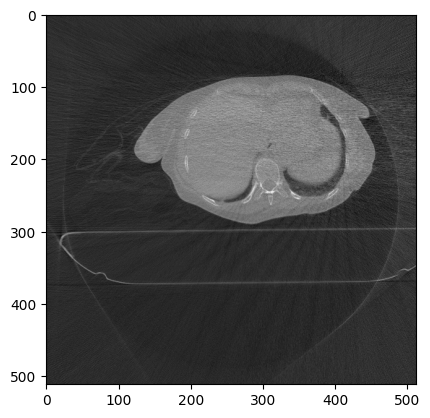

In [27]:
plt.imshow(fdk_half[100, :, :].T, cmap='gray')

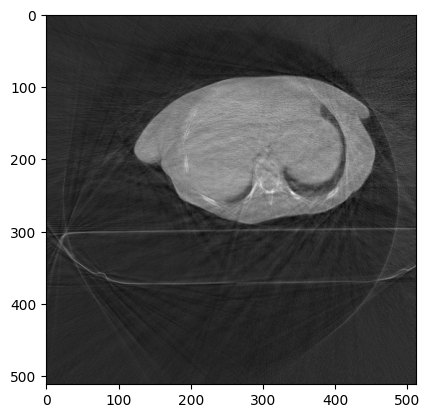

In [28]:
mat = scipy.io.loadmat(os.path.join(RESULT_DIR, 'MK6', 'PROJ_ng_HF_p02_01.mat'))
fdk_half = FDKHalf()(mat['prj'], geo, mat['angles'].flatten(), filter='hann', parker=True)
plt.imshow(fdk_half[100, :, :].T, cmap='gray')

# 6. Aggregate CT volumes for train/val/test

In [ ]:
# Directory for aggregated data saving
vol_agg_dir = os.path.join(DATA_DIR, "agg", "volumes")
ensure_dir(vol_agg_dir)

# Aggregate and save volume data sets
for scan_type in ['HF', 'FF']:
    for sample in ['train', 'validation', 'test']:
        vol_gcbct, vol_ngcbct = aggregate_saved_volumes(scan_type, sample)
        torch.save(vol_gcbct, os.path.join(vol_agg_dir, f"{scan_type}_{sample}_gated.pt"))
        torch.save(vol_ngcbct, os.path.join(vol_agg_dir, f"{scan_type}_{sample}_ng.pt"))

# Free up memory
del vol_gcbct, vol_ngcbct

# 7. Train ID CNN

In [ ]:
# TODO

# 8. Inference on test scans for full 3D

In [ ]:
vol = inference_3d(patient_id, scan_id, 'HF', data_version, model_name, 'tumor_location_panc.pt')